In [43]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D

In [5]:
!pip install niapy --pre


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 3.7 MB/s eta 0:00:00a 0:00:01


In [6]:
from niapy.problems import Problem
from niapy.task import Task
from niapy.algorithms.basic import ParticleSwarmOptimization
from sklearn.svm import SVC

In [7]:
train_data = pd.read_csv('/kaggle/input/diabetes-data-set/diabetes.csv')
train_data.shape

(768, 9)

In [8]:
train_data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [9]:
train_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [10]:
train_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<Axes: ylabel='count'>

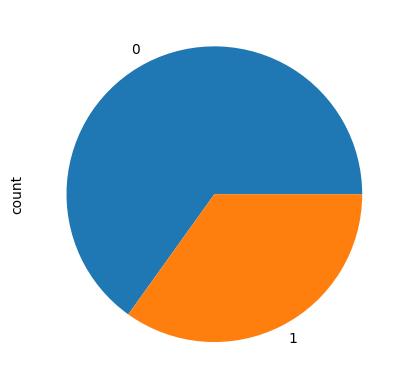

In [11]:
plt_df = train_data.Outcome.value_counts()
plt_df.plot(kind="pie")

In [12]:
x_train = train_data.drop(["Outcome"],axis=1)
x_train.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [13]:
y_train = train_data["Outcome"]
y_train.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [14]:
cgf = x_train.select_dtypes(include='object').columns
cgf

Index([], dtype='object')

In [15]:
imputer = SimpleImputer(strategy="median")
x_train = imputer.fit_transform(x_train)

<Axes: ylabel='count'>

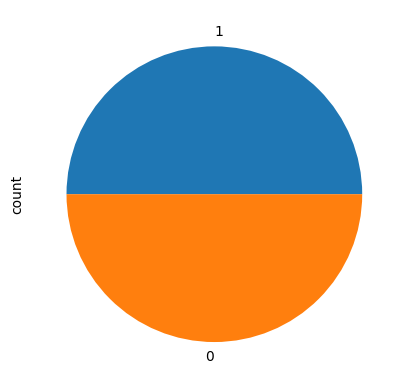

In [16]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)
plot_df = y_train.value_counts()
plot_df.plot(kind="pie")

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=1234)


In [18]:
x_train

array([[  6.        , 148.        ,  72.        , ...,  33.6       ,
          0.627     ,  50.        ],
       [  1.        ,  85.        ,  66.        , ...,  26.6       ,
          0.351     ,  31.        ],
       [  8.        , 183.        ,  64.        , ...,  23.3       ,
          0.672     ,  32.        ],
       ...,
       [  6.65437408, 117.27476437,  96.34562592, ...,  50.93543078,
          0.28634199,  30.89515465],
       [  3.79070986, 147.25574085,  79.25574085, ...,  37.77794901,
          0.54982385,  66.89535493],
       [  5.        ,  74.68588144,  74.72805543, ...,  30.45611086,
          1.11746122,  32.60671286]])

In [19]:
class SVMFeatureSelection(Problem):
    def __init__(self, X_train, y_train, alpha=0.99):
        super().__init__(dimension=X_train.shape[1], lower=0, upper=1)
        self.X_train = X_train
        self.y_train = y_train
        self.alpha = alpha

    def _evaluate(self, x):
        selected = x > 0.5
        num_selected = selected.sum()
        if num_selected == 0:
            return 1.0
        accuracy = cross_val_score(SVC(), self.X_train[:, selected], self.y_train, cv=2, n_jobs=-1).mean()
        score = 1 - accuracy
        num_features = self.X_train.shape[1]
        return self.alpha * score + (1 - self.alpha) * (num_selected / num_features)

In [66]:
problem = SVMFeatureSelection(X_train, y_train)
task = Task(problem, max_iters=100)
algorithm = ParticleSwarmOptimization(population_size=10, seed=1234)
best_features, best_fitness = algorithm.run(task)

selected_features = best_features > 0.5
print('Number of selected features:', selected_features.sum())
print('Selected features:', ', '.join(feature_names[selected_features].tolist()))

model_selected = SVC()
model_all = SVC()

model_selected.fit(X_train[:, selected_features], y_train)
print('Subset accuracy:', model_selected.score(X_test[:, selected_features], y_test))

model_all.fit(X_train, y_train)
print('All Features Accuracy:', model_all.score(X_test, y_test))

Number of selected features: 4


NameError: name 'feature_names' is not defined

In [20]:
x_train_cnn = X_train
x_train_cnn = x_train_cnn.reshape(x_train_cnn.shape[0],x_train_cnn.shape[1],1,1)
y_train_cnn = y_train.values
x_test_cnn = X_test
x_test_cnn = x_test_cnn.reshape(x_test_cnn.shape[0],x_test_cnn.shape[1],1,1)

In [22]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 1), activation='relu', input_shape=(x_train_cnn.shape[1], 1, 1)))
model.add(Conv2D(64, kernel_size=(3, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Conv2D(128, kernel_size=(2, 1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [51]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 1), activation='relu', input_shape=(x_train_cnn.shape[1], 1, 1)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Conv2D(256, kernel_size=(2, 1), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [58]:
class TimeSeriesCNN(tf.keras.Model):
    def __init__(self):
        super(TimeSeriesCNN, self).__init__()

      
        self.conv1 = tf.keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu', input_shape=(x_train_cnn.shape[1], 1, 1))
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu')
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.global_avg_pooling2d = tf.keras.layers.GlobalAveragePooling2D()
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.dense3 = tf.keras.layers.Dense(32, activation='relu')
        self.dropout3 = tf.keras.layers.Dropout(0.5)
        self.predictions = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.batch_norm1(x)
        x = tf.keras.activations.relu(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = tf.keras.activations.relu(x)

        x = self.global_avg_pooling2d(x)

        x = self.dense1(x)
        x = self.dropout1(x)
        x = tf.keras.activations.relu(x)

        x = self.dense2(x)
        x = self.dropout2(x)
        x = tf.keras.activations.relu(x)

        x = self.dense3(x)
        x = self.dropout3(x)
        x = tf.keras.activations.relu(x)

        outputs = self.predictions(x)

        return outputs


In [72]:
model.summary()

Model: "time_series_cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          multiple                  256       
                                                                 
 batch_normalization_9 (Batc  multiple                 256       
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          multiple                  24704     
                                                                 
 batch_normalization_10 (Bat  multiple                 512       
 chNormalization)                                                
                                                                 
 global_average_pooling2d_2   multiple                 0         
 (GlobalAveragePooling2D)                                        
                                                 

In [24]:
def get_callbacks():
    return [
            tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            patience = 5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor = 0.5,
            patience = 3
        ),
    ]

In [59]:
model = TimeSeriesCNN()

In [75]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(x_train_cnn, y_train_cnn, epochs=100,batch_size=128,verbose=1)

Epoch 1/100
7/7 [==============================] - 2s 9ms/step - loss: 0.1194 - accuracy: 0.9563
Epoch 2/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0889 - accuracy: 0.9625
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0919 - accuracy: 0.9613
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0998 - accuracy: 0.9500
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0893 - accuracy: 0.9550
Epoch 6/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0916 - accuracy: 0.9625
Epoch 7/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0944 - accuracy: 0.9575
Epoch 8/100
7/7 [==============================] - 0s 9ms/step - loss: 0.1175 - accuracy: 0.9488
Epoch 9/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0860 - accuracy: 0.9638
Epoch 10/100
7/7 [==============================] - 0s 9ms/step - loss: 0.1056 - accuracy: 0.9638
Epoch 11/100
7/7 [==========

In [76]:
model.evaluate(x_test_cnn,y_test)

7/7 [==============================] - 0s 3ms/step - loss: 2.2271 - accuracy: 0.8200


[2.2270846366882324, 0.8199999928474426]

In [3]:
pip install tabpfn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.6/156.6 kB 3.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [28]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier

classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=32)

classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)

print('Accuracy', accuracy_score(y_test, y_eval))

We have to download the TabPFN, as there is no checkpoint at  /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt
It has about 100MB, so this might take a moment.
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Accuracy 0.82


In [30]:
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)

In [65]:
y = model.predict(x_test_cnn)

7/7 [==============================] - 0s 2ms/step


In [31]:
y_eval

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0])

In [69]:

binary_predictions = (y >= 0.5).astype(int)
binary_predictions.flatten()

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0])

In [71]:
ensemble_pred = (binary_predictions.flatten() + y_eval) >= 1
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print("Ensemble Accuracy:", ensemble_accuracy)

Ensemble Accuracy: 0.81


In [77]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier

classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=128)

classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)

print('Accuracy', accuracy_score(y_test, y_eval))

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Accuracy 0.815


In [78]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier

classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=28)

classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)

print('Accuracy', accuracy_score(y_test, y_eval))

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Accuracy 0.815


In [79]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier

classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=12)

classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)

print('Accuracy', accuracy_score(y_test, y_eval))

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Accuracy 0.825


In [80]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier

classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=6)

classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)

print('Accuracy', accuracy_score(y_test, y_eval))

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Accuracy 0.81


In [81]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier

classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=2)

classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)

print('Accuracy', accuracy_score(y_test, y_eval))

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Accuracy 0.795


In [82]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tabpfn import TabPFNClassifier

classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=256)

classifier.fit(X_train, y_train)
y_eval, p_eval = classifier.predict(X_test, return_winning_probability=True)

print('Accuracy', accuracy_score(y_test, y_eval))

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Accuracy 0.815
